In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import load_img, img_to_array

import matplotlib.pyplot as plt

import cv2

import time

## Loading the images and preprocessing

I chose to load all images into memory, but if you don't have enough memory (around 9.3GB) you can use the generator from keras https://keras.io/preprocessing/image/.

Further we have to preprocess the image to fit the VGG16 model. The model expects a 224 by 224 RGB image.


In [2]:
BASEPATH = "/kaggle/input/custom-cauliflower-dataset/Final Dataset/Train/"

LABELS = set()

paths = []
    
for d in os.listdir(BASEPATH):
    LABELS.add(d)
    paths.append((BASEPATH+d, d))

BASEPATH = "/kaggle/input/custom-cauliflower-dataset/Final Dataset/Test/"
for d in os.listdir(BASEPATH):
    LABELS.add(d)
    paths.append((BASEPATH+d, d))

In [3]:
# resizing and converting to RGB
def load_and_preprocess_image(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (224,224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [4]:
X = []
y = []

for path, label in paths:
    for image_path in os.listdir(path):
        image = load_and_preprocess_image(path+"/"+image_path)
        
        X.append(image)
        y.append(label)

### Encoding the labels

Every model I know of, can only work with numbers, therefore we need to create our label (n02096294-Australian_terrier) to an integer array. This is called **one-hot-encoding**

In [5]:
encoder = LabelBinarizer()

X = np.array(X)
y = encoder.fit_transform(np.array(y))

print(y[0])

[0 0 0 1]


(6843, 224, 224, 3)
(6843, 4)


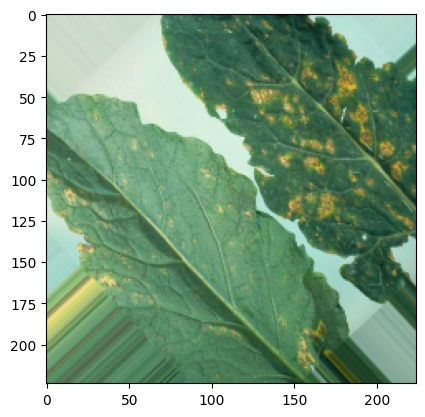

In [6]:
print(X.shape)
print(y.shape)
plt.imshow(X[0])

## Training and evaluating

Now comes to most interesting part. Training and evaluating our model

First step is to create a training and testing dataset

After this I have 2 approaches.
- Creating our own model, which I tried
- Using transfer learning on the VGG16 model

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)

This is the own model I tried. I have to say I did not have a great succes with it. Maybe it needs more finetuning.

In [9]:
model = Sequential()

model.add(Conv2D(64,(3,3),activation="relu", padding="same"))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),activation="relu", padding="same"))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),activation="relu", padding="same"))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),activation="relu", padding="same"))
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3),activation="relu", padding="same"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(1024,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(256,activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(len(LABELS),activation="softmax"))

This is the transfer learning model

I used the VGG16 with the Imagenet weights and did not include the top, so I can add my own top. Being 3 Dense Layers with relu activation, and the last one with softmax and number of neurons is the amount of labels we have.

I set the last 5 layers to trainable, which are the Dense layers I added myself. I don't want to train any layers I get from the pretrained VGG16 model.

In [10]:
base_model=VGG16(weights='imagenet',include_top=False)

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(1024,activation='relu')(x)
x=Dropout(0.5)(x)
x=Dense(512,activation='relu')(x)
preds=Dense(len(LABELS),activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=preds)

for layer in model.layers[:-5]:
    layer.trainable=False
for layer in model.layers[-5:]:
    layer.trainable=True
    
model.compile("adam",loss="categorical_crossentropy",metrics=["accuracy"])

print(model.summary())

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │         525,3

 Total params: 16,816,452 (64.15 MB)

 Trainable params: 2,101,764 (8.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [11]:
# early_stopping = EarlyStopping(patience=5, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3,verbose=1)

### Model training

I used the Adam optimizer, typically my first choice.

I trained the model on 50 epochs, with a batch size of 64, I used two callbacks. Early stopping to stop the training of the validation loss does not improve for 5 epochs, and Reduce LR on plateau to reduce the learning rate to 10% if the validation loss doesn't improve for 3 epochs.

In [12]:
history = model.fit(X_train,y_train,batch_size=64,epochs=10,validation_data=(X_test,y_test), callbacks=[reduce_lr])

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 275ms/step - accuracy: 0.7619 - loss: 2.1096 - val_accuracy: 0.9796 - val_loss: 0.0471 - learning_rate: 0.0010
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.9865 - loss: 0.0421 - val_accuracy: 0.9912 - val_loss: 0.0310 - learning_rate: 0.0010
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.9877 - loss: 0.0379 - val_accuracy: 0.9883 - val_loss: 0.0310 - learning_rate: 0.0010
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.9966 - loss: 0.0102 - val_accuracy: 0.9971 - val_loss: 0.0153 - learning_rate: 0.0010
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.9937 - loss: 0.0241 - val_accuracy: 0.9883 - val_loss: 0.0325 - learning_rate: 0.0010
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.9948 - loss: 0.0164 - val_accuracy: 0.9927 - val_loss: 0.0200 - learning_rate: 0.0010
Epoch 7/10
96/97 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9962 - loss: 0.0

### Evaluation

Last step should always be to evaluate the model

In [13]:
history.history

{'accuracy': [0.8887625932693481,
  0.984085738658905,
  0.9881455302238464,
  0.9936667680740356,
  0.9939915537834167,
  0.9935044050216675,
  0.9964274168014526,
  0.9990256428718567,
  0.9998376369476318,
  1.0],
 'loss': [0.721662163734436,
  0.04825271666049957,
  0.03419045731425285,
  0.01982424035668373,
  0.020432598888874054,
  0.019910220056772232,
  0.013433316722512245,
  0.0019993854220956564,
  0.0009646696271374822,
  0.00027511888765729964],
 'val_accuracy': [0.9795620441436768,
  0.9912408590316772,
  0.9883211851119995,
  0.9970802664756775,
  0.9883211851119995,
  0.9927007555961609,
  0.9912408590316772,
  0.9956204295158386,
  0.9941605925559998,
  0.9941605925559998],
 'val_loss': [0.04710221290588379,
  0.03095283731818199,
  0.031005408614873886,
  0.015299318358302116,
  0.03247588127851486,
  0.019966481253504753,
  0.03187797963619232,
  0.012285537086427212,
  0.015201759524643421,
  0.014568716287612915],
 'learning_rate': [0.0010000000474974513,
  0.0010

In [14]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print(f"loss on the test set is {loss:.2f}")
print(f"accuracy on the test set is {acc:.3f}")

loss on the test set is 0.01
accuracy on the test set is 0.994


As we can see the accuracy on the test set is over 50% maybe by tuning the model and the hyperparameters we could increase this.

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step


<Axes: >

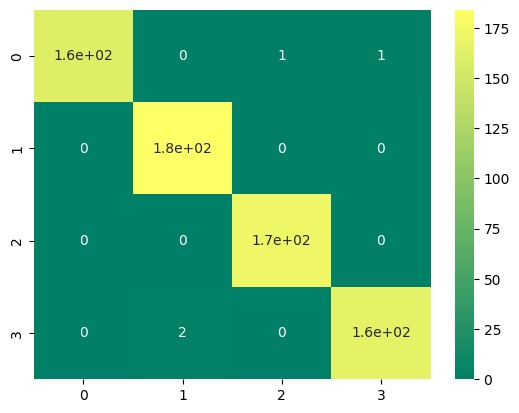

In [15]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_predi=np.argmax(y_pred, axis=1)
y_testi=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_testi , y_predi)

import seaborn as sns
sns.heatmap(cm , cmap="summer" , annot=True)

In [17]:
predictions = model.predict(X_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


In [18]:
label_predictions = encoder.inverse_transform(predictions)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


<Axes: >

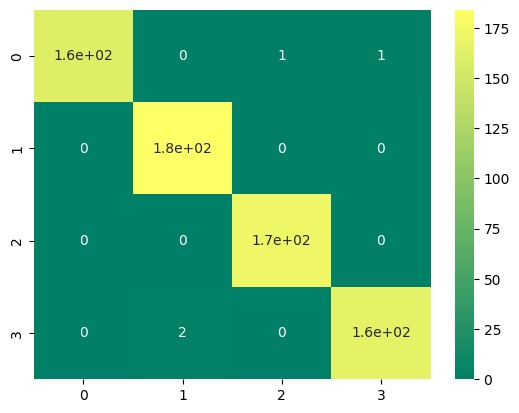

In [19]:
y_pred = model.predict(X_test)
y_predi=np.argmax(y_pred, axis=1)
y_testi=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_testi , y_predi)

import seaborn as sns
sns.heatmap(cm , cmap="summer" , annot=True)

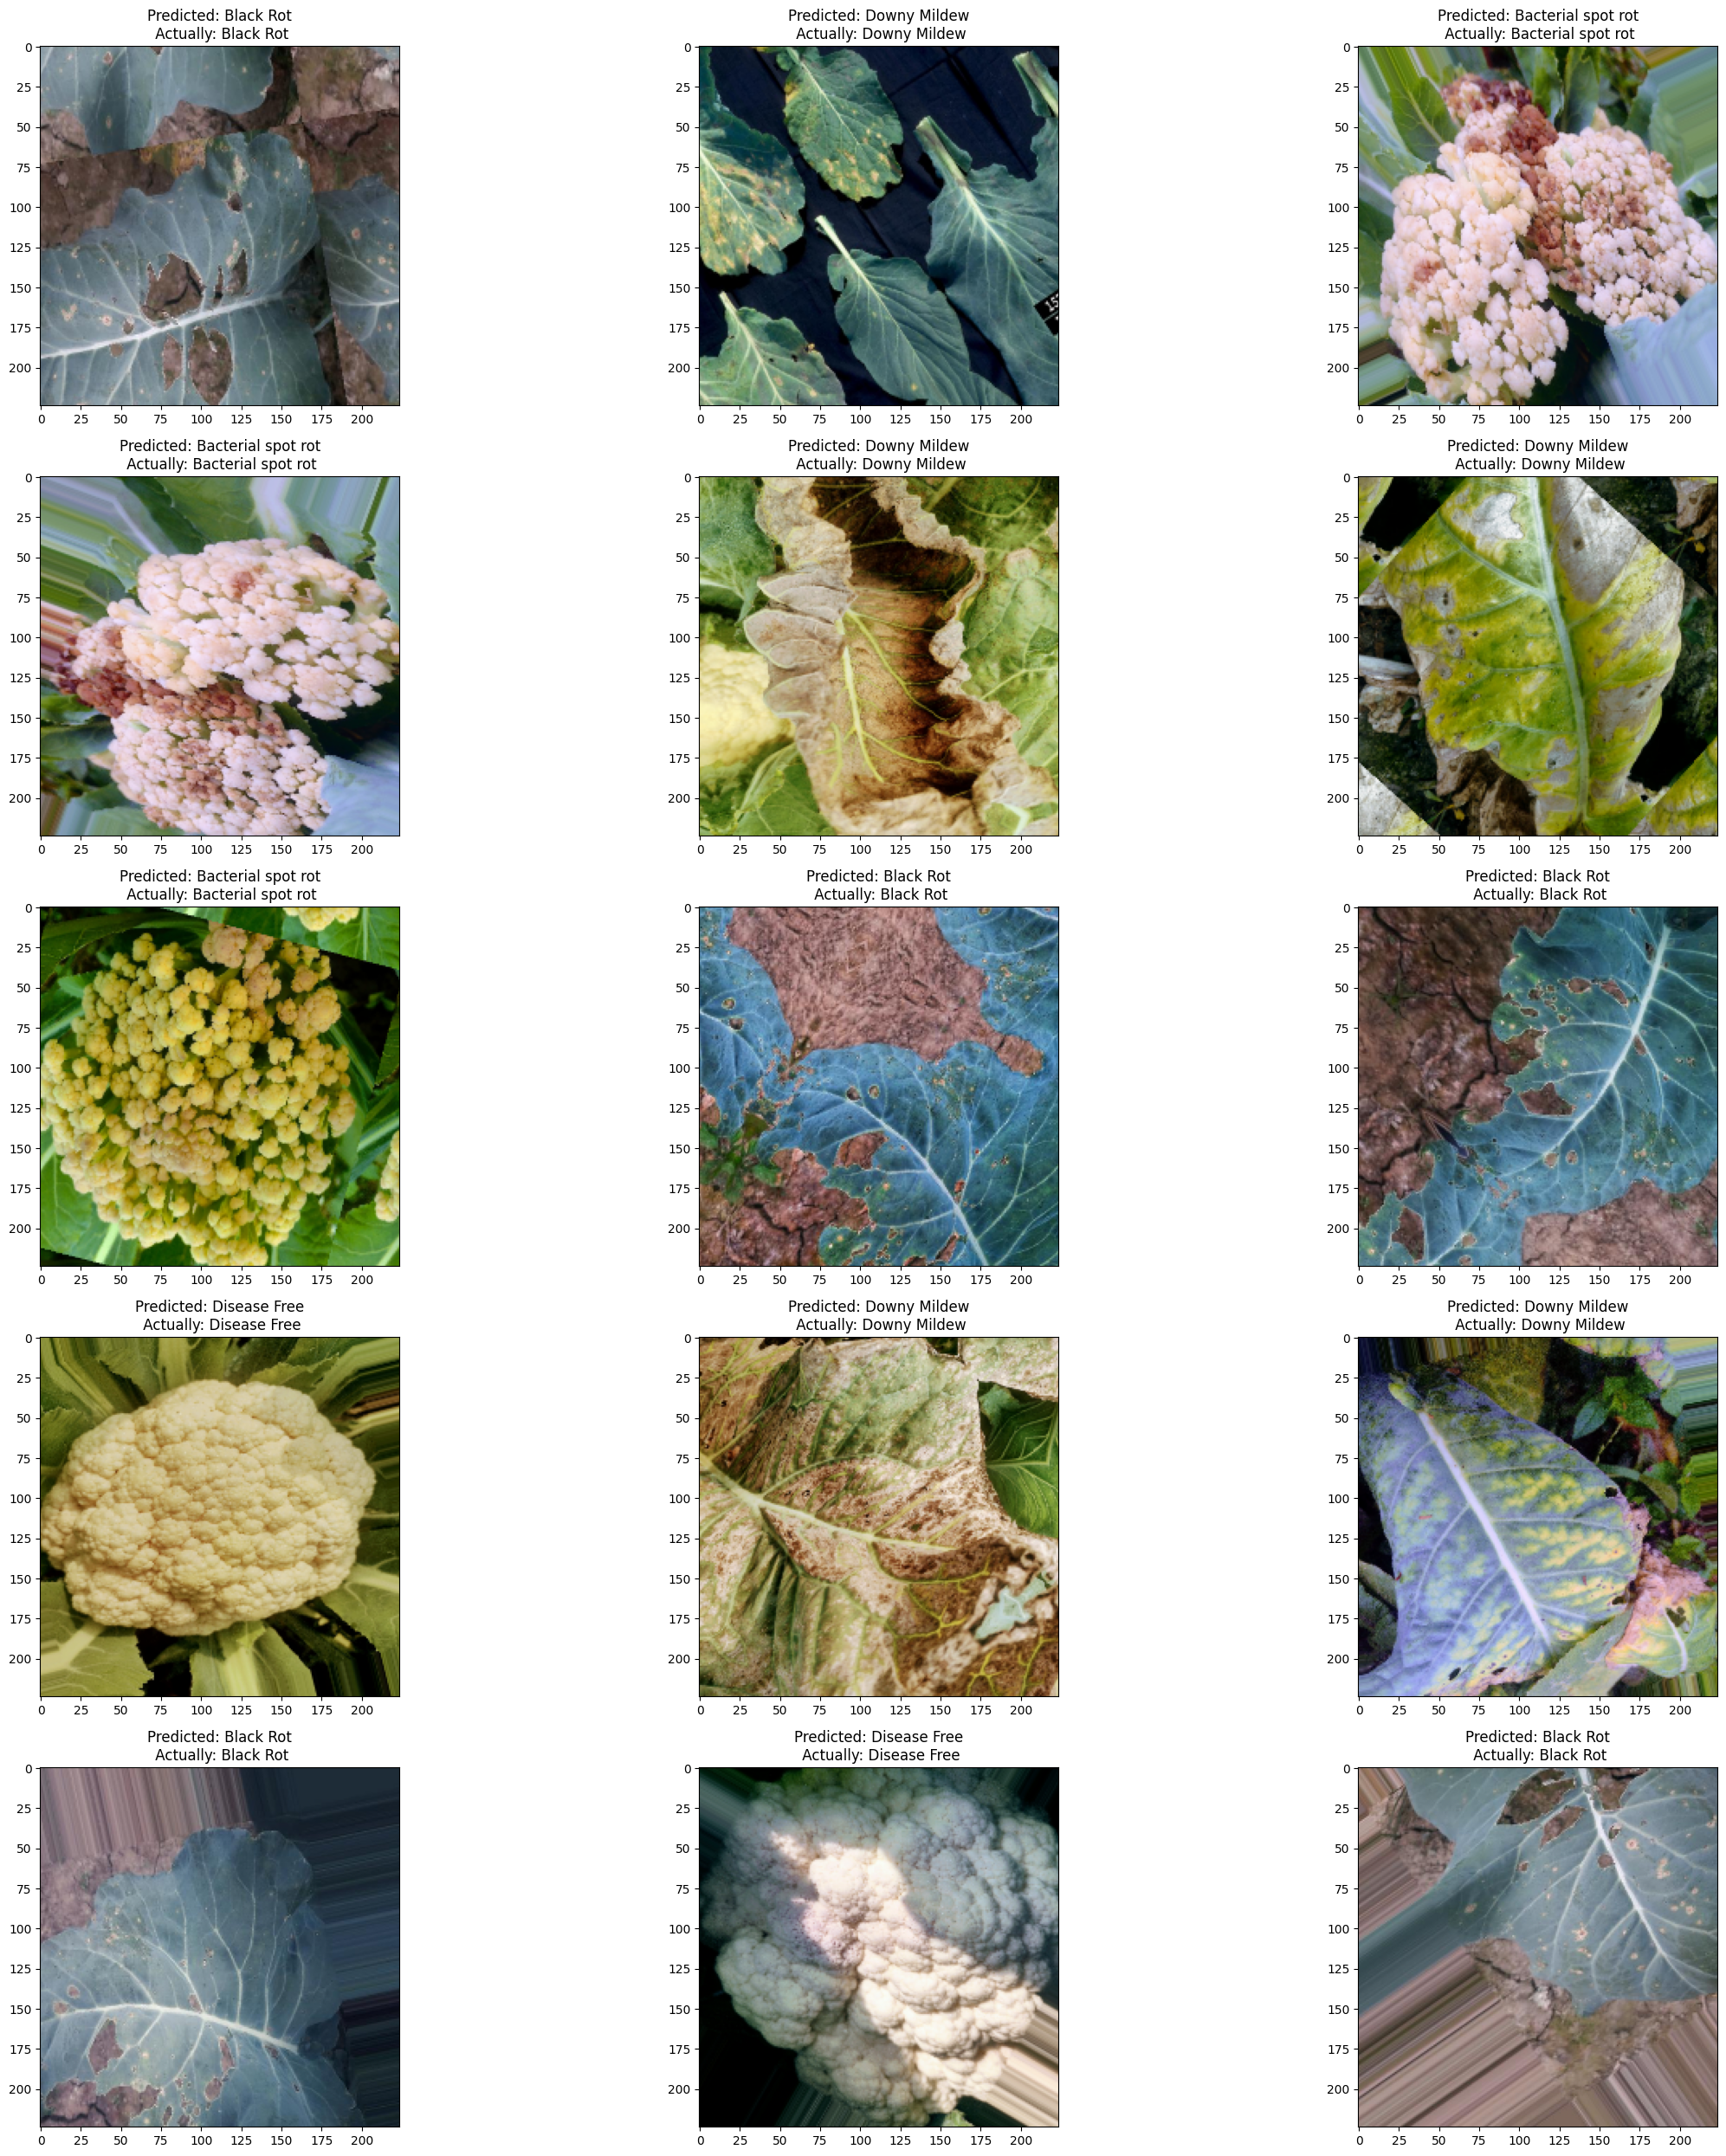

In [20]:
rows, cols = 5, 3
size = 25

fig,ax=plt.subplots(rows,cols)
fig.set_size_inches(size,size)
for i in range(rows):
    for j in range (cols):
        index = np.random.randint(0,len(X_test))
        ax[i,j].imshow(X_test[index])
        ax[i,j].set_title(f'Predicted: {label_predictions[index]}\n Actually: {encoder.inverse_transform(y_test)[index]}')
        
plt.tight_layout()

In [21]:
def measure_prediction_time(model, image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Perform multiple runs to get a more accurate average
    num_runs = 10
    times = []
    
    for _ in range(num_runs):
        # Measure prediction time
        start_time = time.time()
        prediction = model.predict(img_array)
        end_time = time.time()
        
        # Calculate and store prediction time
        times.append(end_time - start_time)
    
    # Calculate statistics
    avg_time = np.mean(times)
    std_time = np.std(times)
    
    print(f"Average Prediction Time: {avg_time:.4f} seconds")
    print(f"Standard Deviation: {std_time:.4f} seconds")
    
    return prediction

In [22]:
prediction = measure_prediction_time(model, '/kaggle/input/custom-cauliflower-dataset/Final Dataset/Test/Bacterial spot rot/Bacterial spot (1000).png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Average Prediction Time: 0.1800 seconds
Standard Deviation: 0.3647 seconds
